In [1]:
#Load
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.ticker as mtick
import sqlite3
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.common.by import By
from bs4 import BeautifulSoup
import time
import requests     # to get images
import shutil       # to save files locally
import datetime
from scipy.stats import norm
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
import os
# NBA API
#from nba_api.stats.static import players
#from nba_api.stats.endpoints import commonplayerinfo
#from nba_api.stats.static import teams

## The Data
The data can be found in three places:
1. Advanced Player Data... Folder '10_yr_player_data'
2. Defensive Dashboard... Folder 'player_d_dash'
3. Shot Dashboard... Folder 'player_shooting_closest_defender_'

## The Metrics and weights


1. Minutes Played - 5% 
2. USG% - 5%
3. 3Pt Open Shooting - 12.5%
4. 2Pt Semi-Guarded Shooting - 12.5%
5. True Shooting - 10%
6. Assist Percentage - 7.5%
7. -Turnovers - 7.5%
8. 3-Pt Defense - 10%
9. Post Defense - 10%
10. 2pt Defense - 10%
11. Rebounding Percentage - 10%

## The Process

- I will create a threshold based on posessions played in a season to include players (500? 1000?)
- I will run each year's decile against that years data
- If a player gets kicked out of the dataset for not enough posessions, we will assume they are slightly under average of the dataset
- Interesting to see how players numbers change over the years

## Check Correlations with wins


In [3]:
# Data
df_21 = pd.read_excel('10_yr_player_data\\advanced_SeasonType_Regular_20Season_Season_2021-22.xlsx')
df_20 = pd.read_excel('10_yr_player_data\\advanced_SeasonType_Regular_20Season_Season_2020-21.xlsx')
df_19 = pd.read_excel('10_yr_player_data\\advanced_SeasonType_Regular_20Season_Season_2019-20.xlsx')
df_18 = pd.read_excel('10_yr_player_data\\advanced_SeasonType_Regular_20Season_Season_2018-19.xlsx')
df_17 = pd.read_excel('10_yr_player_data\\advanced_SeasonType_Regular_20Season_Season_2017-18.xlsx')
df_16 = pd.read_excel('10_yr_player_data\\advanced_SeasonType_Regular_20Season_Season_2016-17.xlsx')
df_15 = pd.read_excel('10_yr_player_data\\advanced_SeasonType_Regular_20Season_Season_2015-16.xlsx')
df_14 = pd.read_excel('10_yr_player_data\\advanced_SeasonType_Regular_20Season_Season_2014-15.xlsx')
df_13 = pd.read_excel('10_yr_player_data\\advanced_SeasonType_Regular_20Season_Season_2013-14.xlsx')
df_12 = pd.read_excel('10_yr_player_data\\advanced_SeasonType_Regular_20Season_Season_2012-13.xlsx')
df_11 = pd.read_excel('10_yr_player_data\\advanced_SeasonType_Regular_20Season_Season_2011-12.xlsx')


In [4]:
df_20.describe().round(1)

,Unnamed: 0,Unnamed: 1,AGE,GP,W,L,MIN,OFFRTG,DEFRTG,NETRTG,...,AST Ratio,OREB%,DREB%,REB%,TO Ratio,eFG%,TS%,USG%,PACE,PIE
count,541.0,540.0,540.0,540.0,540.0,540.0,540.0,540.0,540.0,540.0,...,540.0,540.0,540.0,540.0,540.0,540.0,540.0,540.0,540.0,540.0
mean,270.0,266.4,26.0,42.7,21.5,21.2,19.8,106.8,109.4,-2.6,...,16.6,4.1,13.7,8.9,10.5,51.3,54.4,18.0,101.8,8.6
std,156.3,157.1,4.1,20.7,13.1,11.3,9.3,9.4,7.7,12.7,...,7.9,3.4,5.7,4.1,6.6,10.9,10.6,5.3,3.2,4.8
min,0.0,1.0,19.0,1.0,0.0,0.0,2.0,37.5,70.4,-148.2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.6,94.2,-26.0
25%,135.0,124.0,23.0,26.8,11.0,12.0,12.6,103.3,107.0,-6.4,...,11.4,1.7,9.5,5.8,7.9,48.2,51.3,14.3,99.7,6.7
50%,270.0,268.0,25.0,46.0,21.0,21.0,19.6,108.1,110.0,-1.2,...,15.8,3.0,12.8,8.0,9.7,52.4,55.5,17.3,101.3,8.7
75%,405.0,401.5,29.0,61.0,31.0,29.0,27.7,112.5,112.7,3.0,...,20.9,5.6,16.6,11.0,11.9,56.6,59.8,21.1,103.2,11.0
max,540.0,537.0,41.0,72.0,52.0,53.0,37.6,166.7,185.7,66.7,...,66.7,15.9,38.5,23.3,100.0,100.0,107.8,37.5,123.9,45.5


## Merge all these DFs


In [6]:
dfs = [df_21,df_20, df_19, df_18, df_17, df_16, df_15, df_14, df_13, df_12, df_11]

In [8]:
appended_data = []
i = 2021

for df in dfs:
    df['season'] = i
    appended_data.append(df)
    i -= 1

appended_data = pd.concat(appended_data)
appended_data

,Unnamed: 0,Unnamed: 1,PLAYER,TEAM,AGE,GP,W,L,MIN,OFFRTG,...,DREB%,REB%,TO Ratio,eFG%,TS%,USG%,PACE,PIE,POSS,season
0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021
1,1,1.0,Deni Avdija,WAS,21.0,82.0,35.0,47.0,24.2,109.2,...,18.2,10.6,9.7,50.3,53.6,15.8,99.88,8.6,"4,118",2021
2,2,1.0,Dwight Powell,DAL,30.0,82.0,52.0,30.0,21.9,113.2,...,13.4,11.6,10.0,68.7,72.5,13.6,95.12,10.2,"3,556",2021
3,3,1.0,Kevon Looney,GSW,26.0,82.0,53.0,29.0,21.1,113.2,...,21.0,16.6,10.2,57.1,58.6,12.0,99.65,10.2,"3,574",2021
4,4,1.0,Mikal Bridges,PHX,25.0,82.0,64.0,18.0,34.8,116.7,...,8.9,6.0,5.8,60.1,62.7,14.9,100.59,9.1,"5,976",2021
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
474,474,472.0,Derrick Byars,SAS,28.0,2.0,2.0,0.0,18.4,97.3,...,14.7,12.6,0.0,27.3,39.2,13.4,98.31,7.8,75,2011
475,475,472.0,Earl Barron,GSW,30.0,2.0,1.0,1.0,4.4,88.9,...,0.0,5.9,0.0,50.0,50.0,20.0,99.12,-16.7,18,2011
476,476,472.0,Ike Diogu,SAS,28.0,2.0,1.0,1.0,7.1,139.3,...,7.7,4.0,25.0,0.0,34.7,12.5,94.65,-1.4,28,2011
477,477,472.0,Xavier Silas,PHI,24.0,2.0,1.0,1.0,19.4,83.8,...,5.3,4.3,13.6,30.0,33.7,20.7,92.40,-2.4,74,2011


In [10]:
appended_data.to_excel('final_player_data/2011-2021_advanced_player_data.xlsx')

In [11]:
adv_play = appended_data

In [34]:
adv_play = adv_play.dropna()

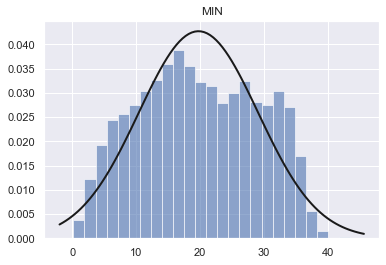

In [35]:
data = adv_play['MIN']
mu, std = norm.fit(data) 
# Plot the histogram.
plt.hist(adv_play['MIN'], bins=25, density=True, alpha=0.6, color='b')
# Plot the PDF.
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std) 
plt.plot(x, p, 'k', linewidth=2)
title = str('MIN')
plt.title(title) 
plt.show()

In [36]:
adv_play

,Unnamed: 0,Unnamed: 1,PLAYER,TEAM,AGE,GP,W,L,MIN,OFFRTG,...,DREB%,REB%,TO Ratio,eFG%,TS%,USG%,PACE,PIE,POSS,season
1,1,1.0,Deni Avdija,WAS,21.0,82.0,35.0,47.0,24.2,109.2,...,18.2,10.6,9.7,50.3,53.6,15.8,99.88,8.6,"4,118",2021
2,2,1.0,Dwight Powell,DAL,30.0,82.0,52.0,30.0,21.9,113.2,...,13.4,11.6,10.0,68.7,72.5,13.6,95.12,10.2,"3,556",2021
3,3,1.0,Kevon Looney,GSW,26.0,82.0,53.0,29.0,21.1,113.2,...,21.0,16.6,10.2,57.1,58.6,12.0,99.65,10.2,"3,574",2021
4,4,1.0,Mikal Bridges,PHX,25.0,82.0,64.0,18.0,34.8,116.7,...,8.9,6.0,5.8,60.1,62.7,14.9,100.59,9.1,"5,976",2021
5,5,1.0,Saddiq Bey,DET,23.0,82.0,23.0,59.0,33.0,104.7,...,12.5,7.8,6.1,48.9,52.9,20.9,99.32,10.0,"5,605",2021
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
474,474,472.0,Derrick Byars,SAS,28.0,2.0,2.0,0.0,18.4,97.3,...,14.7,12.6,0.0,27.3,39.2,13.4,98.31,7.8,75,2011
475,475,472.0,Earl Barron,GSW,30.0,2.0,1.0,1.0,4.4,88.9,...,0.0,5.9,0.0,50.0,50.0,20.0,99.12,-16.7,18,2011
476,476,472.0,Ike Diogu,SAS,28.0,2.0,1.0,1.0,7.1,139.3,...,7.7,4.0,25.0,0.0,34.7,12.5,94.65,-1.4,28,2011
477,477,472.0,Xavier Silas,PHI,24.0,2.0,1.0,1.0,19.4,83.8,...,5.3,4.3,13.6,30.0,33.7,20.7,92.40,-2.4,74,2011


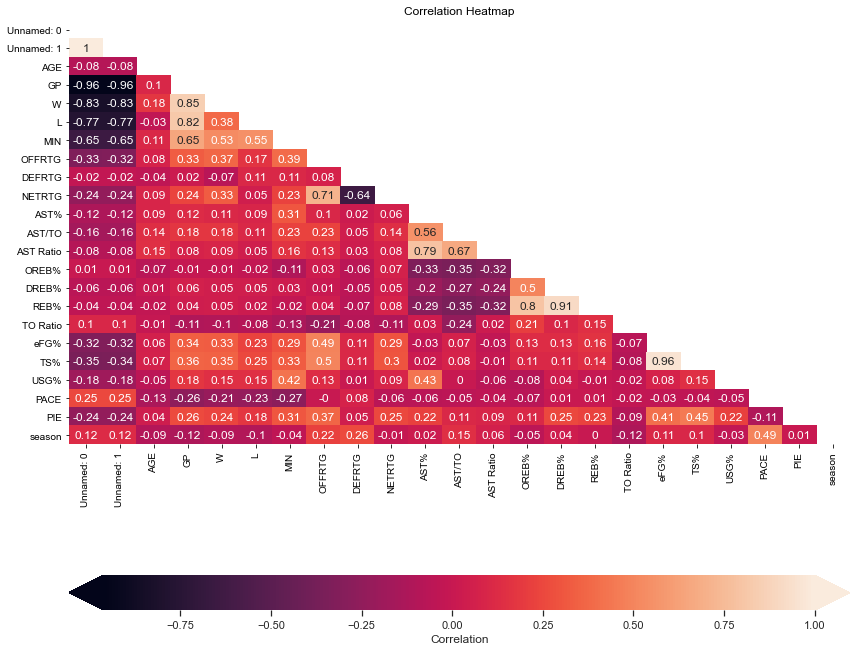

In [13]:
# Create a df with the target as the first column,
# then compute the correlation matrix

#for_viz = pd.concat([y_train, X_train], axis=1)
corr = adv_play.corr()

# Set up figure and axes
fig, ax = plt.subplots(figsize=(14, 12))
sns.set(font_scale = 1)


sns.heatmap(
    data=corr.round(2),
    mask=np.triu(np.ones_like(corr, dtype=bool)),
    ax=ax,
    annot=True,
    cbar_kws={"label": "Correlation", "orientation": "horizontal", "pad": .2, "extend": "both"}
)

ax.set_title("Correlation Heatmap");

In [15]:
adv_play_numeric = adv_play.select_dtypes('number').copy()

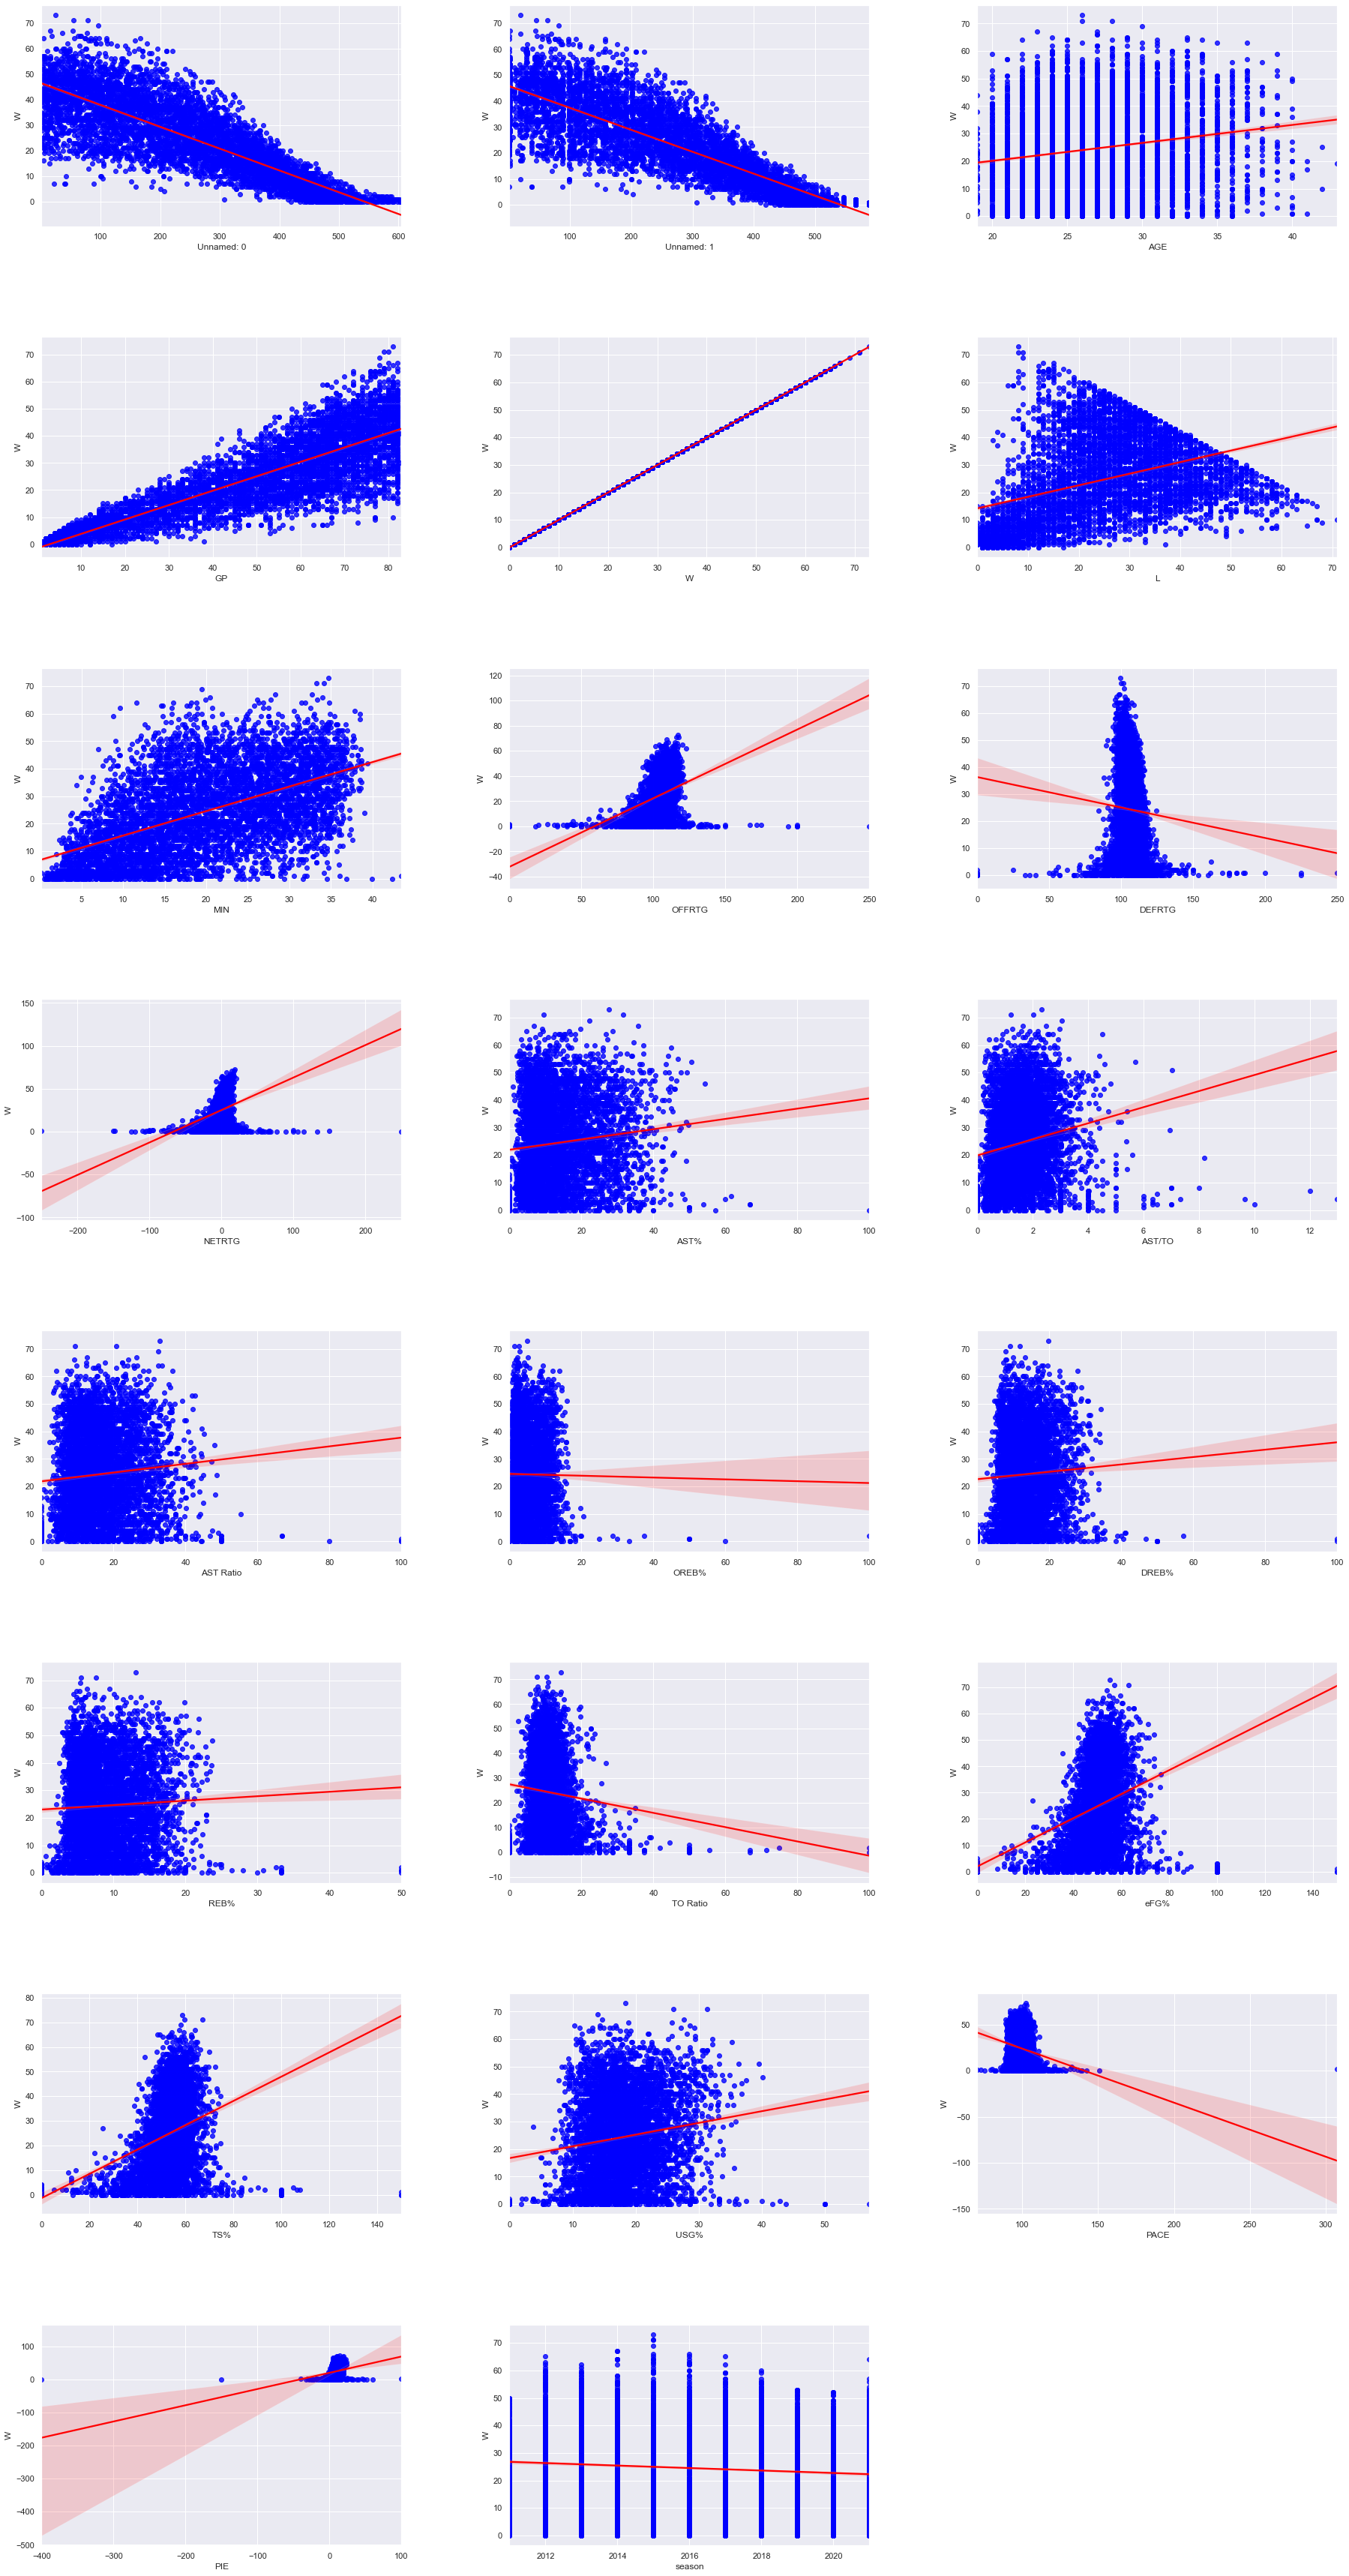

In [17]:
fig = plt.figure(figsize=(30,50))
plt.subplots_adjust(left=0.1,bottom=0.1,right=0.9,top=1.9,wspace=0.3,hspace=0.5)
for i, col in enumerate(adv_play_numeric.columns):
        plt.subplot(15,3,i+1)
        sns.regplot(x=col, y= "W", data=adv_play_numeric, scatter_kws={"color": 'blue'}, line_kws={"color": 'red'})

In [30]:
win_cor = corr['W']
win_cor = pd.DataFrame(win_cor)
win_cor = win_cor.sort_values('W', ascending= False)
win_cor

,W
W,1.000000
GP,0.848061
MIN,0.534595
L,0.384126
OFFRTG,0.367812
TS%,0.345913
NETRTG,0.331974
eFG%,0.330003
PIE,0.238596
AST/TO,0.178766


# END OF WORK ON NEW ONE

In [ ]:
d21 = df_21.T.drop_duplicates().T
d20 = df_20.T.drop_duplicates().T
d19 = df_19.T.drop_duplicates().T
d18 = df_18.T.drop_duplicates().T
d17 = df_17.T.drop_duplicates().T
d21.shape

(377, 67)

In [6]:
da_ds = [d21, d20, d19, d18, d17]

In [7]:
#Check our decile options
pd20 = df_20[d20.columns[d20.columns.str.contains("decile")]]
pd20

,usg_decile,3pt_Def_decile,Def_within10_decile,3pt_decile,Reb_%_decile,AST_%_decile,TOV_%_decile,TS_decile
0,8,9,4,3,3,6,4,1
1,7,3,2,7,2,3,5,6
2,3,4,6,8,2,2,3,8
3,5,2,8,1,1,2,0,0
4,4,6,6,1,9,1,5,8
...,...,...,...,...,...,...,...,...
361,7,1,3,7,5,4,1,4
362,6,9,9,5,8,6,6,4
363,6,0,0,3,4,3,2,7
364,2,0,6,9,6,0,0,9


In [9]:
decile_cols = pd20.columns
decile_cols = list(decile_cols)
decile_cols

['usg_decile',
 '3pt_Def_decile',
 'Def_within10_decile',
 '3pt_decile',
 'Reb_%_decile',
 'AST_%_decile',
 'TOV_%_decile',
 'TS_decile']

In [10]:
colz = ['PLAYER',
 'TEAM_x',
 'MIN_x',
 'TS_decile',
 'usg_decile',
 '3pt_Def_decile',
 'Def_within10_decile',
 '3pt_decile',
 'Reb_%_decile',
 'AST_%_decile',
 'TOV_%_decile'] 

p21= d21[colz]

p21

,PLAYER,TEAM_x,MIN_x,TS_decile,usg_decile,3pt_Def_decile,Def_within10_decile,3pt_decile,Reb_%_decile,AST_%_decile,TOV_%_decile
0,Deni Avdija,WAS,24.2,2,3,1,1,3,6,4,5
1,Dwight Powell,DAL,21.9,9,1,3,7,5,7,2,5
2,Kevon Looney,GSW,21.1,6,0,3,3,0,9,5,6
3,Mikal Bridges,PHX,34.8,9,2,3,5,7,2,2,0
4,Saddiq Bey,DET,33,2,7,6,4,5,5,5,0
...,...,...,...,...,...,...,...,...,...,...,...
372,T.J. McConnell,IND,24.2,1,3,4,6,2,4,9,2
373,Derrick Rose,NYK,24.5,2,7,0,0,8,1,8,4
374,Nerlens Noel,NYK,22.5,6,0,9,1,0,8,0,9
375,Brandon Williams,POR,26.7,0,8,9,4,1,1,8,8


In [11]:
p21['min_decile'] = pd.qcut(p21['MIN_x'], 10, labels=False)

<ipython-input-11-4f9263b04aa6>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  p21['min_decile'] = pd.qcut(p21['MIN_x'], 10, labels=False)


In [12]:
p21['trav_score'] = ((p21['TS_decile'] * .14) + 
                        (p21['3pt_decile'] * .14) + 
                        (p21['AST_%_decile'] * .08) -
                        (p21['TOV_%_decile'] * .08) +                   # negative 3 percent
                        # Defensive Metrics 
                        ((9 - p21['3pt_Def_decile']) * .17) +
                        ((9 - p21['Def_within10_decile']) * .17) +
                        ((9 - p21['Reb_%_decile']) * .10) +
                        # Minutes played and usage
                        (p21['usg_decile'] * .04) +                   
                        (p21['MIN_x'] * .08))                           # players who play more minutes play against better players


p21

<ipython-input-12-cdc44ca19baa>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  p21['trav_score'] = ((p21['TS_decile'] * .14) +


,PLAYER,TEAM_x,MIN_x,TS_decile,usg_decile,3pt_Def_decile,Def_within10_decile,3pt_decile,Reb_%_decile,AST_%_decile,TOV_%_decile,min_decile,trav_score
0,Deni Avdija,WAS,24.2,2,3,1,1,3,6,4,5,5,5.696
1,Dwight Powell,DAL,21.9,9,1,3,7,5,7,2,5,4,5.072
2,Kevon Looney,GSW,21.1,6,0,3,3,0,9,5,6,3,4.488
3,Mikal Bridges,PHX,34.8,9,2,3,5,7,2,2,0,9,7.664
4,Saddiq Bey,DET,33,2,7,6,4,5,5,5,0,8,6.06
...,...,...,...,...,...,...,...,...,...,...,...,...,...
372,T.J. McConnell,IND,24.2,1,3,4,6,2,4,9,2,5,4.896
373,Derrick Rose,NYK,24.5,2,7,0,0,8,1,8,4,5,7.82
374,Nerlens Noel,NYK,22.5,6,0,9,1,0,8,0,9,4,3.38
375,Brandon Williams,POR,26.7,0,8,9,4,1,1,8,8,6,4.246


In [13]:
for d in da_ds: 
    d['trav_score'] = ((d['TS_decile'] * .14) + 
                        (d['3pt_decile'] * .14) + 
                        (d['AST_%_decile'] * .08) -
                        (d['TOV_%_decile'] * .08) +                   # negative 3 percent
                        # Defensive Metrics 
                        ((9 - d['3pt_Def_decile']) * .17) +
                        ((9 - d['Def_within10_decile']) * .17) +
                        ((9 - d['Reb_%_decile']) * .10) +
                        # Minutes played and usage
                        (d['usg_decile'] * .04) +                   
                        (d['MIN_x'] * .08))                           # players who play more minutes play against better players



In [14]:
p21.sort_values('trav_score', ascending=False, inplace= True)
p21.head(25)

<ipython-input-14-6ac605689c73>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  p21.sort_values('trav_score', ascending=False, inplace= True)


,PLAYER,TEAM_x,MIN_x,TS_decile,usg_decile,3pt_Def_decile,Def_within10_decile,3pt_decile,Reb_%_decile,AST_%_decile,TOV_%_decile,min_decile,trav_score
370,Kyrie Irving,BKN,37.6,7,9,5,2,9,1,8,2,9,8.758
55,Tyrese Maxey,PHI,35.3,7,6,4,4,9,0,7,0,9,8.464
241,LeBron James,LAL,37.2,8,9,3,0,6,7,9,6,9,8.286
35,Desmond Bane,MEM,29.8,7,7,3,1,9,3,5,1,7,8.204
182,Stephen Curry,GSW,34.5,7,9,1,3,7,4,9,6,9,8.2
364,Klay Thompson,GSW,29.4,3,9,1,1,8,2,6,0,7,8.152
251,Kevin Durant,BKN,37.2,9,9,5,1,7,6,8,6,9,8.076
164,Fred VanVleet,TOR,37.9,4,8,4,2,7,1,8,4,9,8.052
229,Eric Gordon,HOU,29.3,8,5,2,2,9,0,5,8,7,7.964
123,Devin Booker,PHX,34.5,5,9,2,3,7,4,7,2,9,7.91


In [15]:
p21.trav_score = p21.trav_score.astype(str).astype(np.float64)

c:\Users\tmcro\anaconda3\envs\learn-env\lib\site-packages\pandas\core\generic.py:5168: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [16]:
group = p21.groupby('TEAM_x')['trav_score'].agg(['sum', 'mean', 'count'])

In [17]:
group

,sum,mean,count
TEAM_x,,,
ATL,61.612,5.601091,11
BKN,71.188,5.476000,13
BOS,59.068,5.906800,10
CHA,58.376,5.837600,10
CHI,64.108,5.342333,12
CLE,67.378,5.614833,12
DAL,64.110,5.342500,12
DEN,68.094,5.238000,13
DET,60.296,5.024667,12


In [18]:
por = p21.loc[p21['TEAM_x']== "POR"]
por

,PLAYER,TEAM_x,MIN_x,TS_decile,usg_decile,3pt_Def_decile,Def_within10_decile,3pt_decile,Reb_%_decile,AST_%_decile,TOV_%_decile,min_decile,trav_score
369,Damian Lillard,POR,36.4,3,9,5,6,3,1,9,4,9,6.502
337,Nassir Little,POR,25.9,5,2,0,1,4,6,1,3,5,6.442
228,Anfernee Simons,POR,29.5,6,8,8,9,9,0,7,5,7,6.010
327,Joe Ingles,POR,24.9,3,1,0,9,5,1,7,4,5,5.722
265,Josh Hart,POR,33.2,8,5,7,7,5,7,7,7,8,5.556
259,Eric Bledsoe,POR,25.2,1,6,5,2,2,3,8,9,5,5.066
352,Keon Johnson,POR,18.8,0,6,0,9,4,1,6,7,2,4.554
175,Ben McLemore,POR,20.1,5,6,8,9,6,0,2,2,3,4.458
375,Brandon Williams,POR,26.7,0,8,9,4,1,1,8,8,6,4.246
240,Jusuf Nurkic,POR,28.2,6,8,9,4,1,9,6,9,6,4.166


In [19]:
bos = p21.loc[p21['TEAM_x']== "BOS"]
bos

,PLAYER,TEAM_x,MIN_x,TS_decile,usg_decile,3pt_Def_decile,Def_within10_decile,3pt_decile,Reb_%_decile,AST_%_decile,TOV_%_decile,min_decile,trav_score
39,Jayson Tatum,BOS,35.9,6,9,2,1,5,7,7,4,9,7.762
150,Jaylen Brown,BOS,33.6,5,9,4,3,6,5,6,5,8,6.938
97,Payton Pritchard,BOS,14.1,6,5,2,2,9,3,7,1,0,6.888
109,Al Horford,BOS,29.1,5,2,3,0,4,8,6,1,7,6.718
208,Robert Williams III,BOS,29.6,9,0,1,0,0,9,3,6,7,6.278
28,Grant Williams,BOS,24.4,9,0,6,2,9,4,0,6,5,6.192
48,Derrick White,BOS,29.3,3,6,7,1,2,1,8,3,7,6.184
92,Marcus Smart,BOS,32.3,2,4,2,7,4,1,8,7,8,5.994
316,Daniel Theis,BOS,20.8,7,3,3,5,2,7,1,7,3,4.464
272,Aaron Nesmith,BOS,11,1,3,9,6,1,4,0,8,0,1.650


### Sort by TScore, Filter out by Min, Games Played

In [22]:
d21

,Unnamed: 0,Unnamed: 0.1,Unnamed: 0_x,Unnamed: 1_x,PLAYER,TEAM_x,AGE_x,GP_x,W_x,L_x,...,ins_10_D_FG%,TS_decile,usg_decile,3pt_Def_decile,Def_within10_decile,3pt_decile,Reb_%_decile,AST_%_decile,TOV_%_decile,trav_score
0,0,0,1,1,Deni Avdija,WAS,21,82,35,47,...,52.2,2,3,1,1,3,6,4,5,5.696
1,1,1,2,1,Dwight Powell,DAL,30,82,52,30,...,59.8,9,1,3,7,5,7,2,5,5.072
2,2,2,3,1,Kevon Looney,GSW,26,82,53,29,...,56.1,6,0,3,3,0,9,5,6,4.488
3,3,3,4,1,Mikal Bridges,PHX,25,82,64,18,...,58.3,9,2,3,5,7,2,2,0,7.664
4,4,4,5,1,Saddiq Bey,DET,23,82,23,59,...,56.7,2,7,6,4,5,5,5,0,6.06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
372,372,414,415,414,T.J. McConnell,IND,30,27,9,18,...,59.2,1,3,4,6,2,4,9,2,4.896
373,373,416,417,417,Derrick Rose,NYK,33,26,11,15,...,45.6,2,7,0,0,8,1,8,4,7.82
374,374,421,422,420,Nerlens Noel,NYK,28,25,10,15,...,52,6,0,9,1,0,8,0,9,3.38
375,375,422,423,423,Brandon Williams,POR,22,24,2,22,...,56.5,0,8,9,4,1,1,8,8,4.246


In [27]:
dfilt21 = d21.dropna()
dfilt21 = dfilt21.drop(columns = ['Unnamed: 0', 'Unnamed: 0.1', 'Unnamed: 0_x', 'Unnamed: 1_x'])
dfilt21 = dfilt21.loc[dfilt21['MIN_x'] > 15]
dfilt21 = dfilt21.loc[:,~dfilt21.columns.duplicated()]
dfilt21 = dfilt21.loc[dfilt21['GP_x'] > 30]
dfilt21 = dfilt21.sort_values('trav_score', ascending = False)
dfilt21.head()


,PLAYER,TEAM_x,AGE_x,GP_x,W_x,L_x,MIN_x,OFFRTG,DEFRTG,NETRTG,...,ins_10_D_FG%,TS_decile,usg_decile,3pt_Def_decile,Def_within10_decile,3pt_decile,Reb_%_decile,AST_%_decile,TOV_%_decile,trav_score
55,Tyrese Maxey,PHI,21,75,45,30,35.3,113.3,109.7,3.6,...,57.3,7,6,4,4,9,0,7,0,8.464
241,LeBron James,LAL,37,56,25,31,37.2,110.9,113.5,-2.5,...,51.8,8,9,3,0,6,7,9,6,8.286
35,Desmond Bane,MEM,23,76,53,23,29.8,114.7,107.8,6.9,...,52,7,7,3,1,9,3,5,1,8.204
182,Stephen Curry,GSW,34,64,45,19,34.5,114.1,103.4,10.7,...,55.6,7,9,1,3,7,4,9,6,8.2
364,Klay Thompson,GSW,32,32,17,15,29.4,111.4,108,3.3,...,53.4,3,9,1,1,8,2,6,0,8.152


In [29]:
dfilt20 = d20.dropna()
dfilt20 = dfilt20.drop(columns = ['Unnamed: 0', 'Unnamed: 0.1', 'Unnamed: 1_x'])
dfilt20 = dfilt20.loc[dfilt20['MIN_x'] > 15]
dfilt20 = dfilt20.loc[:,~dfilt20.columns.duplicated()]
dfilt20 = dfilt20.loc[dfilt20['GP_x'] > 30]
dfilt20 = dfilt20.sort_values('trav_score', ascending = False)
dfilt20.head()

,PLAYER,TEAM_x,AGE_x,GP_x,W_x,L_x,MIN_x,OFFRTG,DEFRTG,NETRTG,...,ins_10_D_FG%,usg_decile,3pt_Def_decile,Def_within10_decile,3pt_decile,Reb_%_decile,AST_%_decile,TOV_%_decile,TS_decile,trav_score
335,Kevin Durant,BKN,32,35,23,12,33.1,121.7,111.1,10.7,...,50.8,9,1,0,9,7,8,7,9,8.698
283,LeBron James,LAL,36,45,30,15,33.4,112.4,103.2,9.2,...,51,9,0,0,5,7,9,7,7,8.132
288,Bogdan Bogdanovic,ATL,28,44,30,14,29.7,114.9,111,3.9,...,51.7,6,6,1,9,2,7,1,8,8.046
170,Zach LaVine,CHI,26,58,26,32,35.1,112.4,113.1,-0.8,...,55.2,9,4,3,9,4,8,7,8,7.998
338,Shai Gilgeous-Alexander,OKC,22,35,16,19,33.7,107.2,114.9,-7.7,...,57.9,9,2,6,9,3,9,6,8,7.976


In [31]:
dfilt19 = d19.dropna()
dfilt19 = dfilt19.drop(columns = ['Unnamed: 0', 'Unnamed: 0.1', 'Unnamed: 1_x'])
dfilt19 = dfilt19.loc[dfilt19['MIN_x'] > 15]
dfilt19 = dfilt19.loc[:,~dfilt19.columns.duplicated()]
dfilt19 = dfilt19.loc[dfilt19['GP_x'] > 30]
dfilt19 = dfilt19.sort_values('trav_score', ascending = False)
dfilt19.head()

,PLAYER,TEAM_x,AGE_x,GP_x,W_x,L_x,MIN_x,OFFRTG,DEFRTG,NETRTG,...,ins_10_D_FG%,usg_decile,3pt_Def_decile,Def_within10_decile,3pt_decile,Reb_%_decile,AST_%_decile,TOV_%_decile,TS_decile,trav_score
234,Fred VanVleet,TOR,26,54,40,14,35.7,109.1,104.3,4.8,...,54.3,7,3,3,8,1,8,3,4,8.056
132,Khris Middleton,MIL,28,62,46,16,29.9,113.3,100.9,12.4,...,49.8,8,5,0,9,6,8,3,8,8.002
72,Damian Lillard,POR,29,66,33,33,37.5,115.7,114.3,1.4,...,60.6,9,5,8,8,1,9,2,9,7.95
240,LaMarcus Aldridge,SAS,34,53,23,30,33.1,110.2,113.4,-3.2,...,50.6,8,2,1,8,7,5,0,5,7.938
160,Zach LaVine,CHI,25,60,20,40,34.8,106.8,111.2,-4.4,...,52.2,9,3,1,7,3,8,7,5,7.884


In [33]:
dfilt18 = d18.dropna()
dfilt18 = dfilt18.drop(columns = ['Unnamed: 0', 'Unnamed: 0.1', 'Unnamed: 1_x'])
dfilt18 = dfilt18.loc[dfilt18['MIN_x'] > 15]
dfilt18 = dfilt18.loc[:,~dfilt18.columns.duplicated()]
dfilt18 = dfilt18.loc[dfilt18['GP_x'] > 30]
dfilt18 = dfilt18.sort_values('trav_score', ascending = False)
dfilt18.head()

,PLAYER,TEAM_x,AGE_x,GP_x,W_x,L_x,MIN_x,OFFRTG,DEFRTG,NETRTG,...,ins_10_D_FG%,usg_decile,3pt_Def_decile,Def_within10_decile,3pt_decile,Reb_%_decile,AST_%_decile,TOV_%_decile,TS_decile,trav_score
70,Kevin Durant,GSW,30,78,54,24,34.6,118.7,107.3,11.4,...,50.8,9,1,0,5,5,8,5,9,8.618
174,Spencer Dinwiddie,BKN,26,68,36,32,28.1,107.1,109.8,-2.7,...,42.9,8,0,0,4,0,9,6,7,8.308
269,LeBron James,LAL,34,55,28,27,35.2,109.6,107.6,2,...,51,9,0,0,4,7,9,5,7,8.296
284,Derrick Rose,MIN,30,51,24,27,27.3,111.5,110.8,0.7,...,54.3,9,2,2,7,0,8,0,5,8.144
85,Paul George,OKC,29,77,46,31,36.9,112.1,103.9,8.2,...,57.5,9,1,5,8,6,6,3,7,7.992


In [34]:
dfilt17 = d17.dropna()
dfilt17 = dfilt17.drop(columns = ['Unnamed: 0', 'Unnamed: 0.1', 'Unnamed: 1_x'])
dfilt17 = dfilt17.loc[dfilt17['MIN_x'] > 15]
dfilt17 = dfilt17.loc[:,~dfilt17.columns.duplicated()]
dfilt17 = dfilt17.loc[dfilt17['GP_x'] > 30]
dfilt17 = dfilt17.sort_values('trav_score', ascending = False)
dfilt17.head()

,PLAYER,TEAM_x,AGE_x,GP_x,W_x,L_x,MIN_x,OFFRTG,DEFRTG,NETRTG,...,ins_10_D_FG%,usg_decile,3pt_Def_decile,Def_within10_decile,3pt_decile,Reb_%_decile,AST_%_decile,TOV_%_decile,TS_decile,trav_score
141,Klay Thompson,GSW,28,73,55,18,34.3,112.6,105.6,7.1,...,50.1,8,5,0,9,2,4,1,8,8.594
76,Kyle Lowry,TOR,32,78,57,21,32.2,113.1,105.5,7.6,...,52,6,2,1,8,5,9,4,8,8.406
66,Paul George,OKC,28,79,47,32,36.6,109.7,106,3.7,...,52.9,8,1,2,8,4,6,5,6,8.338
194,Kevin Durant,GSW,29,68,49,19,34.2,115.9,108.9,7,...,50.8,9,6,0,9,6,8,5,9,8.196
156,James Harden,HOU,28,72,59,13,35.4,116.2,106.2,10,...,54.6,9,2,3,6,5,9,7,9,8.062


In [41]:
dfilt21.to_excel('final_player_data\\All Player Data With Deciles - Filtered 2021.xlsx')
dfilt20.to_excel('final_player_data\\All Player Data With Deciles - Filtered 2020.xlsx')
dfilt19.to_excel('final_player_data\\All Player Data With Deciles - Filtered 2019.xlsx')
dfilt18.to_excel('final_player_data\\All Player Data With Deciles - Filtered 2018.xlsx')
dfilt17.to_excel('final_player_data\\All Player Data With Deciles - Filtered 2017.xlsx')

### Top 25 players by Year

Note that this is by relative efficiency in different areas of basketball

In [35]:
colz1 = colz + ['TEAM_x', 'trav_score']

In [36]:
dfilt21[colz1].head(25)

,PLAYER,TEAM_x,MIN_x,TS_decile,usg_decile,3pt_Def_decile,Def_within10_decile,3pt_decile,Reb_%_decile,AST_%_decile,TOV_%_decile,TEAM_x,trav_score
55,Tyrese Maxey,PHI,35.3,7,6,4,4,9,0,7,0,PHI,8.464
241,LeBron James,LAL,37.2,8,9,3,0,6,7,9,6,LAL,8.286
35,Desmond Bane,MEM,29.8,7,7,3,1,9,3,5,1,MEM,8.204
182,Stephen Curry,GSW,34.5,7,9,1,3,7,4,9,6,GSW,8.2
364,Klay Thompson,GSW,29.4,3,9,1,1,8,2,6,0,GSW,8.152
251,Kevin Durant,BKN,37.2,9,9,5,1,7,6,8,6,BKN,8.076
164,Fred VanVleet,TOR,37.9,4,8,4,2,7,1,8,4,TOR,8.052
229,Eric Gordon,HOU,29.3,8,5,2,2,9,0,5,8,HOU,7.964
123,Devin Booker,PHX,34.5,5,9,2,3,7,4,7,2,PHX,7.91
106,Luke Kennard,LAC,27.4,8,3,3,3,9,1,4,1,LAC,7.772


In [37]:
dfilt20[colz1].head(25)

,PLAYER,TEAM_x,MIN_x,TS_decile,usg_decile,3pt_Def_decile,Def_within10_decile,3pt_decile,Reb_%_decile,AST_%_decile,TOV_%_decile,TEAM_x,trav_score
335,Kevin Durant,BKN,33.1,9,9,1,0,9,7,8,7,BKN,8.698
283,LeBron James,LAL,33.4,7,9,0,0,5,7,9,7,LAL,8.132
288,Bogdan Bogdanovic,ATL,29.7,8,6,6,1,9,2,7,1,ATL,8.046
170,Zach LaVine,CHI,35.1,8,9,4,3,9,4,8,7,CHI,7.998
338,Shai Gilgeous-Alexander,OKC,33.7,8,9,2,6,9,3,9,6,OKC,7.976
249,Alec Burks,NYK,25.6,4,6,0,0,9,5,5,1,NYK,7.888
289,Gordon Hayward,CHA,34,6,8,4,2,9,5,7,4,CHA,7.82
10,RJ Barrett,NYK,34.9,2,7,1,1,8,4,5,4,NYK,7.772
113,Stephen Curry,GSW,34.2,9,9,5,5,9,4,9,6,GSW,7.716
239,Derrick Rose,NYK,25.6,3,8,1,2,7,1,9,2,NYK,7.678


In [38]:
dfilt19[colz1].head(25)

,PLAYER,TEAM_x,MIN_x,TS_decile,usg_decile,3pt_Def_decile,Def_within10_decile,3pt_decile,Reb_%_decile,AST_%_decile,TOV_%_decile,TEAM_x,trav_score
234,Fred VanVleet,TOR,35.7,4,7,3,3,8,1,8,3,TOR,8.056
132,Khris Middleton,MIL,29.9,8,8,5,0,9,6,8,3,MIL,8.002
72,Damian Lillard,POR,37.5,9,9,5,8,8,1,9,2,POR,7.95
240,LaMarcus Aldridge,SAS,33.1,5,8,2,1,8,7,5,0,SAS,7.938
160,Zach LaVine,CHI,34.8,5,9,3,1,7,3,8,7,CHI,7.884
123,Anthony Davis,LAL,34.4,8,9,1,0,3,8,6,3,LAL,7.882
29,CJ McCollum,POR,36.5,3,8,5,2,7,1,7,0,POR,7.87
54,James Harden,HOU,36.5,9,9,3,3,5,5,9,7,HOU,7.84
181,Kyle Lowry,TOR,36.2,7,7,2,3,5,3,9,7,TOR,7.826
210,Kemba Walker,BOS,31.1,6,9,5,3,7,2,8,2,BOS,7.548


In [39]:
dfilt18[colz1].head(25)

,PLAYER,TEAM_x,MIN_x,TS_decile,usg_decile,3pt_Def_decile,Def_within10_decile,3pt_decile,Reb_%_decile,AST_%_decile,TOV_%_decile,TEAM_x,trav_score
70,Kevin Durant,GSW,34.6,9,9,1,0,5,5,8,5,GSW,8.618
174,Spencer Dinwiddie,BKN,28.1,7,8,0,0,4,0,9,6,BKN,8.308
269,LeBron James,LAL,35.2,7,9,0,0,4,7,9,5,LAL,8.296
284,Derrick Rose,MIN,27.3,5,9,2,2,7,0,8,0,MIN,8.144
85,Paul George,OKC,36.9,7,9,1,5,8,6,6,3,OKC,7.992
13,Monte Morris,DEN,24,6,4,3,2,9,0,8,0,DEN,7.93
22,Bojan Bogdanovic,IND,31.8,8,7,4,2,9,3,3,3,IND,7.844
152,Mike Conley,MEM,33.5,6,9,8,1,6,1,9,0,MEM,7.77
160,Stephen Curry,GSW,33.8,9,9,5,5,9,4,8,4,GSW,7.764
156,Darius Miller,NOP,25.5,4,1,0,0,7,0,4,2,NOP,7.74


In [40]:
dfilt17[colz1].head(25)

,PLAYER,TEAM_x,MIN_x,TS_decile,usg_decile,3pt_Def_decile,Def_within10_decile,3pt_decile,Reb_%_decile,AST_%_decile,TOV_%_decile,TEAM_x,trav_score
141,Klay Thompson,GSW,34.3,8,8,5,0,9,2,4,1,GSW,8.594
76,Kyle Lowry,TOR,32.2,8,6,2,1,8,5,9,4,TOR,8.406
66,Paul George,OKC,36.6,6,8,1,2,8,4,6,5,OKC,8.338
194,Kevin Durant,GSW,34.2,9,9,6,0,9,6,8,5,GSW,8.196
156,James Harden,HOU,35.4,9,9,2,3,6,5,9,7,HOU,8.062
303,Tyreke Evans,MEM,30.9,5,9,2,2,8,5,9,3,MEM,7.912
153,Al Horford,BOS,31.6,6,5,1,2,9,7,8,4,BOS,7.898
94,Courtney Lee,NYK,30.4,5,3,2,2,8,1,5,1,NYK,7.872
248,Jimmy Butler,MIN,36.7,7,8,3,4,5,4,7,0,MIN,7.866
107,Giannis Antetokounmpo,MIL,36.7,8,9,2,0,2,8,8,4,MIL,7.836
